In [129]:
import numpy as np
import pandas as pd
import scipy as sc
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
import sklearn as sk
from tqdm import tqdm

class DimReductionEvaluation:
    def __init__(self, data=None):
        # data in the form of a pandas dataframe with the following columns:
        #     - image: the image file
        #     - label: the label of the image
        self.data = data
        
    def get_data_from_folder(self, folder_path, image_sise):
        # specify the shape of the resized image
        shape = (image_sise, image_sise)  

        self.image_size = image_sise
        self.image_shape = shape
        # Create an empty dictionary to store the data
        data = {'image': [], 'label': [], 'numpy': [], 'numpy_grayscale': []}

        # loop through each category folder
        for category in os.listdir(folder_path):
            category_path = os.path.join(folder_path, category)
            if os.path.isdir(category_path):
                # loop through each image file in the category folder
                for file in os.listdir(category_path):
                    file_path = os.path.join(category_path, file)
                    if os.path.isfile(file_path):
                        # open the image file and resize it
                        with Image.open(file_path) as image:
                            label = category
                            # Add the image and label to the dictionary
                            data['image'].append(image)
                            data['label'].append(label)
                            data['numpy'].append(np.array(image.resize(shape)).reshape(-1)/255)
                            data['numpy_grayscale'].append(np.array(image.resize(shape)).mean(axis=-1).reshape(-1)/255)
        # Convert the dictionary to a pandas dataframe
        data['numpy_normalized']=list(sk.preprocessing.normalize(np.array(data['numpy'])))
        data['numpy_grayscale_normalized']=list(sk.preprocessing.normalize(np.array(data['numpy_grayscale'])))
        self.data = pd.DataFrame(data)
        

In [94]:

# Set the path to the folder containing the image data
data_path = '../dataset/input_resized/flowers/'

# Create an instance of the DimReductionEvaluation class
dre = DimReductionEvaluation()
dre.get_data_from_folder(data_path, 256)

In [130]:
# Range of K values to test
k_range=np.linspace(10, 700, 20).astype(np.int64)

# Number of samples to use
N=350

error_RP=[]
error_SRP=[]

sample=np.array([x for x in dre.data.sample(2*N)
                 ['numpy_normalized'].to_numpy()])

def calculate_reduction_error(sample, r_space_dim_range):
    error_RP=[]
    error_SRP=[]

    x1=sample[:N]
    x2=sample[N:]
    for k in tqdm(r_space_dim_range):
        # Linear Projection for the currnet k
        RP_=GaussianRandomProjection(n_components=k)
        RP_.fit(x1)
        RP=RP_.transform
        SRP_=SparseRandomProjection(n_components=k)
        SRP_.fit(x1)
        SRP=SRP_.transform

        # Calculate the reconstruction error
        d=np.linalg.norm(x1-x2, axis=1)
        d_RP=np.linalg.norm(RP(x1)-RP(x2), axis=1)*np.sqrt(x1.shape[1]/k)
        d_SRP=np.linalg.norm(SRP(x1)-SRP(x2), axis=1)*np.sqrt(x1.shape[1]/k)

        error_SRP.append((d-d_SRP))
        error_RP.append((d-d_RP))

    error_RP=np.array(error_RP)
    error_SRP=np.array(error_SRP)
    error={'RP': error_RP, 'SRP': error_SRP}
    return error

error=calculate_reduction_error(sample, k_range)

100%|██████████| 20/20 [01:15<00:00,  3.78s/it]


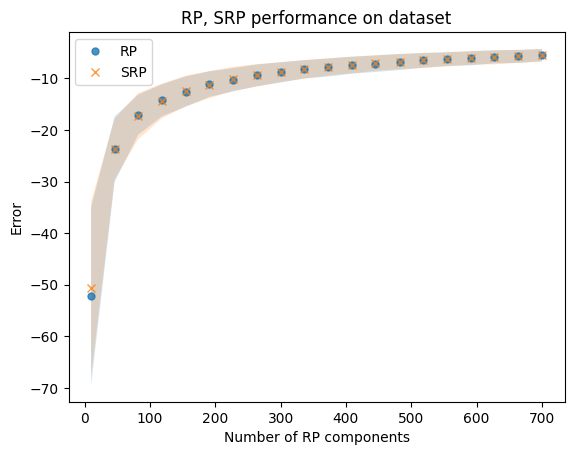

In [137]:
#Making nice plot
def plot_reduction_error(error, ax):
        for error, plot_style, markersize, linewidth, label in zip(error.values(),
                                ['o', 'x'], [5, 6], [2, 10], ['RP', 'SRP']):
                                
                ax.plot(k_range, error.mean(axis=-1), plot_style, markersize=markersize,
                        linewidth=linewidth, label=label, alpha=0.8)
                ax.fill_between(k_range, error.mean(axis=-1) - error.std(axis=-1),
                                error.mean(axis=-1) + error.std(axis=-1), alpha=0.2)

        ax.legend(loc='best')
        ax.set_xlabel('Number of RP components')
        ax.set_ylabel('Error')
        ax.set_title('RP, SRP performance on dataset')
fig, ax = plt.subplots()
plot_reduction_error(error, ax)
plt.show()
# (d1-d2).mean()


In [77]:
sample.mean(axis=-1)

array([0.00333851, 0.00366817, 0.00371871, 0.00322371, 0.00350691,
       0.00356233, 0.00362924, 0.00319127, 0.00270629, 0.0029562 ,
       0.00363508, 0.00369908, 0.00356182, 0.002505  , 0.00275149,
       0.00361528, 0.00322657, 0.0035638 , 0.00375594, 0.0036314 ,
       0.00357425, 0.00334359, 0.0032713 , 0.00349128, 0.00345343,
       0.00361275, 0.00338366, 0.00353794, 0.00259134, 0.00310819,
       0.00307839, 0.00348457, 0.00356413, 0.00337093, 0.00382914,
       0.00347188, 0.00329284, 0.00358647, 0.00383994, 0.00325449,
       0.00370198, 0.00220928, 0.00369616, 0.0029381 , 0.00344228,
       0.00379783, 0.00374497, 0.00363402, 0.00336426, 0.00359176,
       0.00359347, 0.0034286 , 0.00292661, 0.00351138, 0.00364022,
       0.0033806 , 0.00295333, 0.00325929, 0.00353655, 0.00320836,
       0.00326869, 0.00356994, 0.00353921, 0.00323892, 0.00347114,
       0.00344419, 0.00329903, 0.00342496, 0.00335411, 0.00337823,
       0.00364241, 0.00289749, 0.003364  , 0.00379236, 0.00346

In [136]:
error_by_label={}
N=100
for label in dre.data['label'].unique():
    sample=np.array([x for x in (dre.data.loc[dre.data['label'] == label])
                    .sample(2*N)['numpy_grayscale_normalized'].to_numpy()])
    error=calculate_reduction_error(sample, k_range)
    error_by_label[label]=error


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


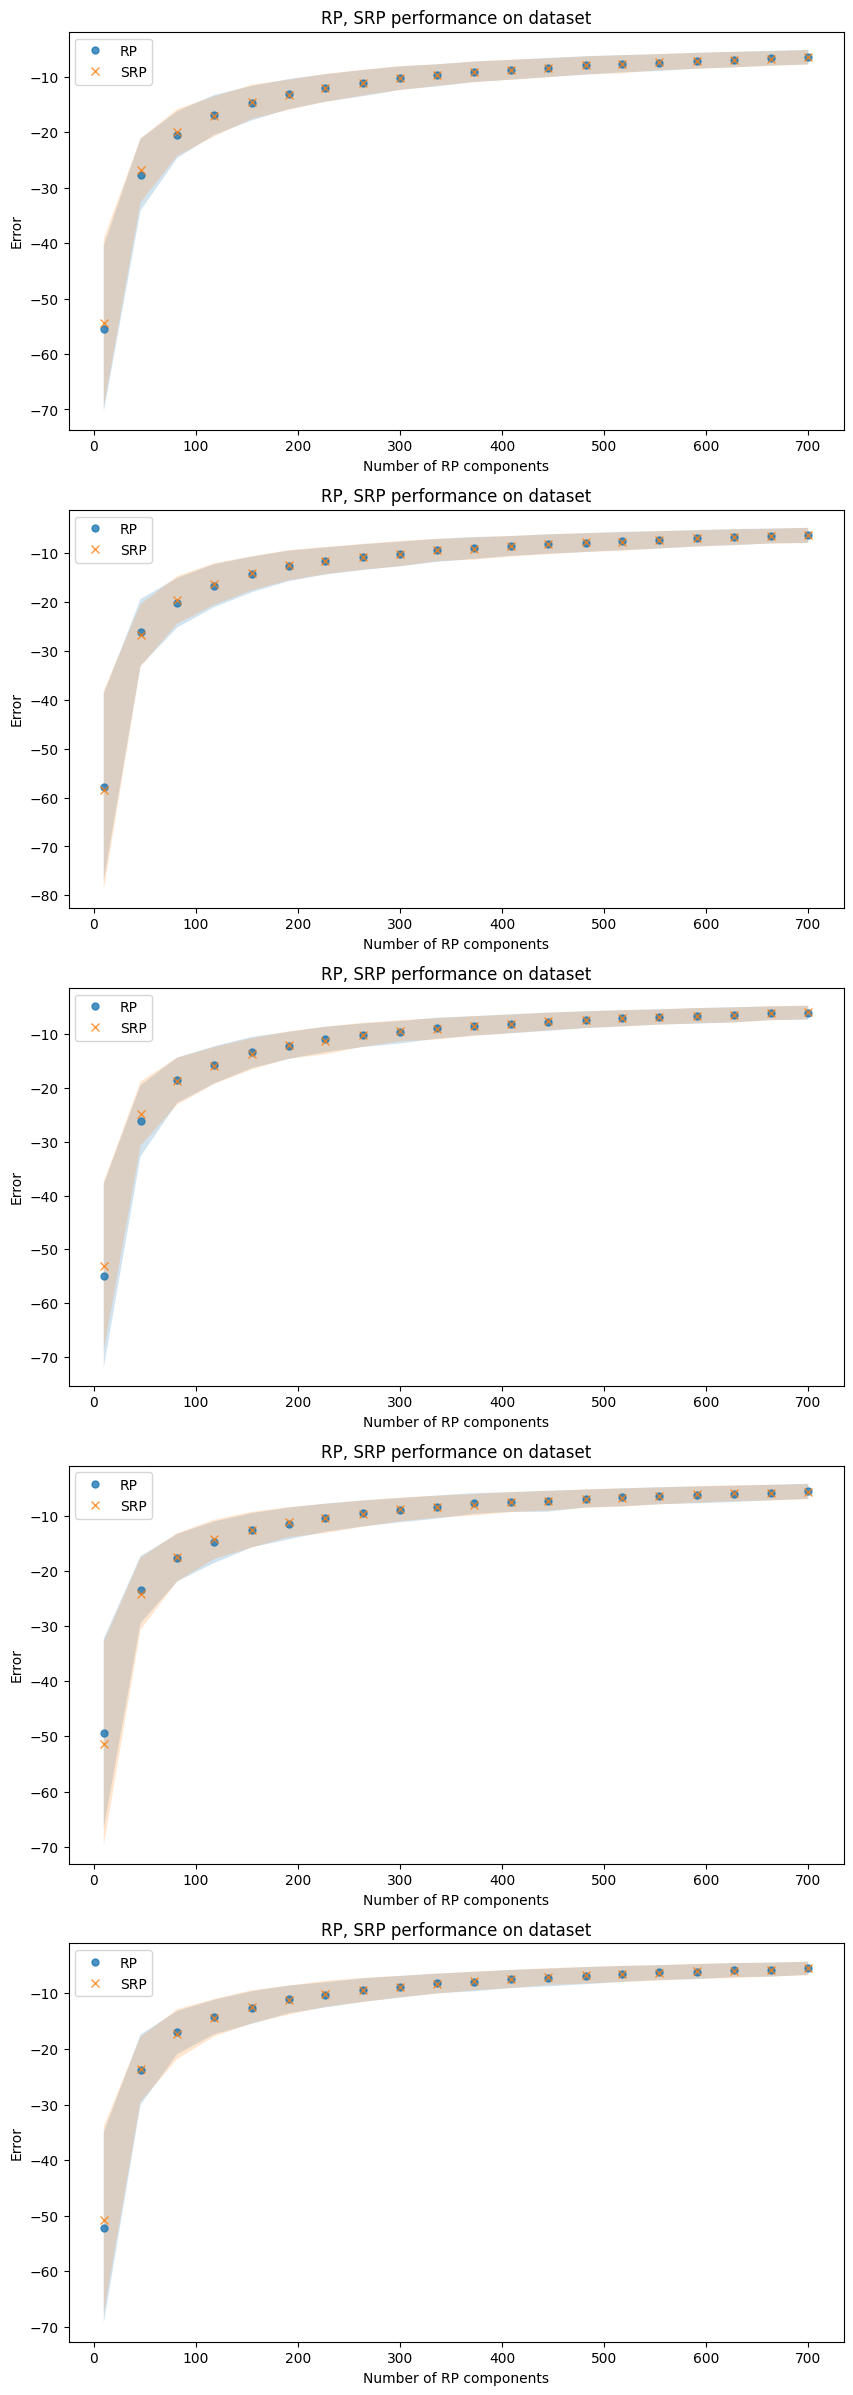

In [140]:
fig, axes = plt.subplots(5,1, figsize=(10, 30))
for ax, error in zip(axes, error_by_label.values()):
    plot_reduction_error(error, ax)
plt.show()